`
Project:  Project 1: Benson
Date:     01/23/2017
Name:     Prashant Tatineni
Team:     Connor Stefan, Prashant Tatineni, Rosie Hoyem
`

# Summary of Solution Steps
1. Use Census tract data to locate high density residential areas specifically for women working in tech.
2. Join Census data with MTA station locations retrieved from ArcGIS.
3. Use MTA turnstile data to find highest volume stations.
4. Create a combined rank accounting for total volume and count of female tech workers.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image

%matplotlib inline

## Step 1
This python script takes in the dataset from census.gov and reformats the Census Tract value to match the format in the table downloaded from ArcGIS. It then returns 2 columns, `census_tracts` and `counts` of women in each of those census tracts.

In [5]:
df_input = pd.read_csv('data/raw/ACS_15_5YR_C24010_with_ann.csv')

census_tracts = []
counts = []
for index, row in df_input.iterrows():
	if index != 0:
		counts.append(int(row['HD01_VD43']))
		county_code = row['GEO.id2'][3:5]
		tract_code = row['GEO.id2'][5:]
		if county_code == '61':
			census_tracts.append('1' + tract_code)
		if county_code == '05':
			census_tracts.append('2' + tract_code)
		if county_code == '47':
			census_tracts.append('3' + tract_code)
		if county_code == '81':
			census_tracts.append('4' + tract_code)
		if county_code == '85':
			census_tracts.append('5' + tract_code)

df_output = pd.DataFrame({'BoroCT2010':census_tracts, 'stem_women':counts})
df_output.to_csv('data/stem_women.csv', index=False)

## Step 2
Merge census data with ArcGIS data.

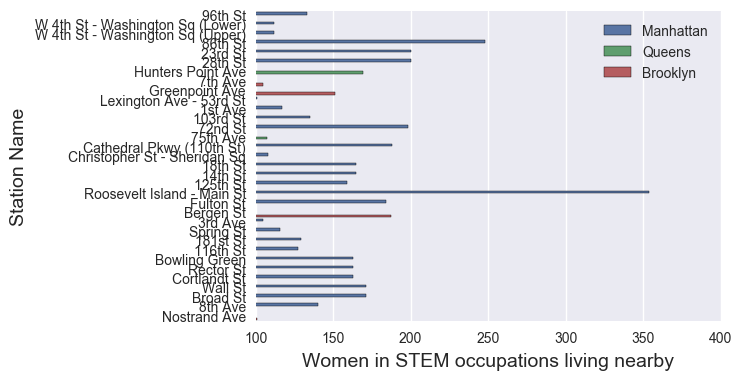

In [6]:
stations = pd.read_csv('data/raw/subway_station_tracts.csv')
stem_women = pd.read_csv('data/stem_women.csv')
df = pd.merge(stations, stem_women, on='BoroCT2010')

dfviz = df[df['stem_women'] > 100]

sns.barplot(x=dfviz['stem_women'], y=dfviz['name'], hue=dfviz['BoroName'], ci=None);
plt.xlabel('Women in STEM occupations living nearby',fontsize=14);
plt.ylabel('Station Name',fontsize=14);
plt.legend(loc=1);
plt.xlim(100,400);

In [7]:
dft50 = df[df['stem_women'] > 50].sort_values('stem_women', ascending=False)[['name','BoroName','BoroCT2010','stem_women']]
sorted_stations = dft50.groupby(['name','BoroName','BoroCT2010']).max().sort_values('stem_women', ascending=False).head(50)
sorted_stations.to_csv('data/top50_stations_women.csv')

## Step 3
Import and clean MTA turnstile data for highest volume stations.

In [10]:
df1 = pd.read_csv('http://web.mta.info/developers/data/nyct/turnstile/turnstile_160507.txt')
df2 = pd.read_csv('http://web.mta.info/developers/data/nyct/turnstile/turnstile_160514.txt')
df3 = pd.read_csv('http://web.mta.info/developers/data/nyct/turnstile/turnstile_160521.txt')
df4 = pd.read_csv('http://web.mta.info/developers/data/nyct/turnstile/turnstile_160528.txt')
frames = [df1, df2, df3, df4]
df = pd.concat(frames)

In [21]:
df.columns = (u'C/A', u'UNIT', u'SCP', u'STATION', u'LINENAME', u'DIVISION', u'DATE',
       u'TIME', u'DESC', u'ENTRIES',
       u'EXITS')
df = df.sort(['C/A','UNIT','SCP','DATE','TIME'])
df['diffEntries'] = df.ENTRIES.diff()
df['diffExits'] = df.EXITS.diff()
df['machine_change'] = (df.SCP != df.SCP.shift())

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


In [22]:
# Edit records where turnstile machine changes; set to 0.
df = df.reset_index(drop=True)
df.diffEntries[df.index[df.machine_change==True]] = 0
df.diffExits[df.index[df.machine_change==True]] = 0

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [23]:
# Further edit records where turnstile counter resulted in negative counts or counts > 6000; reset to 0.
df['counterReset'] = ((df.diffEntries > 6000) | (df.diffEntries < 0) | (df.diffExits > 6000) | (df.diffExits < 0))
df.diffEntries[df.index[df.counterReset==True]] = 0
df.diffExits[df.index[df.counterReset==True]] = 0
df.head()

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,diffEntries,diffExits,machine_change,counterReset
0,A002,R051,02-00-00,59 ST,NQR456,BMT,04/30/2016,00:00:00,REGULAR,5639941,1909983,0.0,0.0,True,False
1,A002,R051,02-00-00,59 ST,NQR456,BMT,04/30/2016,04:00:00,REGULAR,5639991,1909993,50.0,10.0,False,False
2,A002,R051,02-00-00,59 ST,NQR456,BMT,04/30/2016,08:00:00,REGULAR,5640014,1910024,23.0,31.0,False,False
3,A002,R051,02-00-00,59 ST,NQR456,BMT,04/30/2016,12:00:00,REGULAR,5640158,1910134,144.0,110.0,False,False
4,A002,R051,02-00-00,59 ST,NQR456,BMT,04/30/2016,16:00:00,REGULAR,5640454,1910197,296.0,63.0,False,False


In [26]:
df['TotalVol'] = df.diffEntries+df.diffExits
topstations = df.groupby(['STATION']).sum()
topstations = topstations.sort('TotalVol', ascending=False)
topstations.to_csv('data/volumeByStation.csv')

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  app.launch_new_instance()


## Step 4
Combined rank using top50_stations_women.csv and volumeByStation.csv

In [28]:
census = pd.read_csv('data/top50_stations_women.csv')

In [33]:
# Top 5 stations by women residents in tech occupations
census['census_rank'] = census.index + 1
census.head()

,name,BoroName,BoroCT2010,stem_women,census_rank
0,Roosevelt Island - Main St,Manhattan,1023801,354,1
1,86th St,Manhattan,1017500,248,2
2,72nd St,Manhattan,1012600,224,3
3,28th St,Manhattan,1006800,200,4
4,23rd St,Manhattan,1006800,200,5


In [34]:
ts = (pd.read_csv('data/volumeByStation.csv'))[:51]
ts['ts_rank']= ts.index + 1
ts.head()

,STATION,ENTRIES,EXITS,diffEntries,diffExits,machine_change,counterReset,TotalVol,ts_rank
0,34 ST-PENN STA,488881015020,287627882120,4206635.0,3584248.0,100.0,7.0,7790883.0,1
1,GRD CNTRL-42 ST,744724963097,146796271108,3574172.0,3192641.0,61.0,152.0,6766813.0,2
2,34 ST-HERALD SQ,563482244287,596750042788,3026299.0,2691563.0,54.0,91.0,5717862.0,3
3,14 ST-UNION SQ,239944636667,85311655366,2759008.0,2377425.0,38.0,0.0,5136433.0,4
4,23 ST,1111704579992,1034681559184,2922280.0,2197775.0,71.0,339.0,5120055.0,5


In [35]:
import re

capitalizer = lambda x: x.upper()
census['name'] = census['name'].apply(capitalizer)

clean_ave = lambda x: re.sub('AVE','AV', x)
census['name'] = census['name'].apply(clean_ave)

clean_numbers1 = lambda x: re.sub(r'(\b\d+)(RD\b)',r'\1', x)
census['name'] = census['name'].apply(clean_numbers1)

clean_numbers2 = lambda x: re.sub(r'(\b\d+)(TH\b)',r'\1', x)
census['name'] = census['name'].apply(clean_numbers2)

clean_numbers3 = lambda x: re.sub(r'(\b\d+)(ST\b)',r'\1', x)
census['name'] = census['name'].apply(clean_numbers3)

clean_numbers4 = lambda x: re.sub(r'(\b\d+)(ND\b)',r'\1', x)
census['name'] = census['name'].apply(clean_numbers4)

clean_dashes = lambda x: re.sub(r'(\w*)(\s-\s)(\w*)',r'\1-\3', x)
census['name'] = census['name'].apply(clean_dashes)

remove_parans = lambda x: re.sub(r'\(.*\)',r'', x)
census['name'] = census['name'].apply(remove_parans)

census.replace('CONCOURSE', 'CONC', inplace=True)
census.replace('AVENUE', 'AV', inplace=True)
census.replace('WASHINGTON', 'WASH', inplace=True)
census.replace('JUNCTION', 'JCT', inplace=True)
census.replace('CONCOURSE', 'CONC', inplace=True)
census.replace('WOODHAVN', 'WOODHAVEN', inplace=True)
census.replace('CENTER', 'CTR', inplace=True)
census.replace('QUEENSBRIDGE', 'QNSBRIDGE', inplace=True)
census.replace('W 4 ST-WASHINGTON SQ ', 'W 4 ST-WASH SQ', inplace=True)

In [37]:
census_ts = pd.merge(census, ts, how='inner', left_on='name', right_on='STATION')
census_ts['comb_rank'] = census_ts['ts_rank'] + census_ts['census_rank']


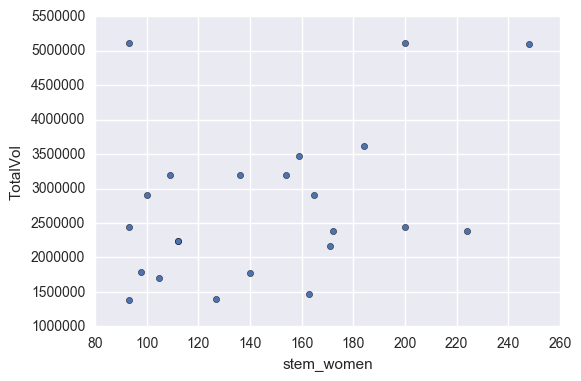

In [38]:
census_ts.plot.scatter('stem_women', 'TotalVol');

In [39]:
final = census_ts.sort_values('comb_rank', ascending=True)
final.head()

,name,BoroName,BoroCT2010,stem_women,census_rank,STATION,ENTRIES,EXITS,diffEntries,diffExits,machine_change,counterReset,TotalVol,ts_rank,comb_rank
0,86 ST,Manhattan,1017500,248,2,86 ST,394240269476,430100768929,2785046.0,2316859.0,52.0,172.0,5101905.0,6,8
5,23 ST,Manhattan,1006800,200,5,23 ST,1111704579992,1034681559184,2922280.0,2197775.0,71.0,339.0,5120055.0,5,10
7,FULTON ST,Manhattan,1001502,184,8,FULTON ST,681257714035,716552976737,1975340.0,1646421.0,96.0,5.0,3621761.0,9,17
1,72 ST,Manhattan,1012600,224,3,72 ST,486479372196,495763311658,1262418.0,1120278.0,25.0,167.0,2382696.0,20,23
3,28 ST,Manhattan,1006800,200,4,28 ST,270514360108,370396202879,1268076.0,1168521.0,37.0,3.0,2436597.0,19,23
